# COGS 108 - EDA Checkpoint

# Names

- Sharon Chen
- Pamela Ghag
- Yuzi Chu
- Cheng Chang
- Stanley Hahm

<a id='research_question'></a>
# Research Question

Are there significant differences among courses under the Humanities, Social Sciences, and STEM departments at UCSD in terms of the correlation between course difficulty (as indicated through average GPA) and teachers’ ratings on the student-feedback platforms (CAPE)?

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import patsy
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# The seaborn library makes plots look nicer
# sns.set(context = 'talk', style='white')

# Set font size for graph labels
sns.set(font_scale = 2)

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

# Make plots just slightly bigger for displaying well in notebook
# set plotting size parameter
plt.rcParams['figure.figsize'] = (10, 20)

In [2]:
# Read in data
cape = pd.read_csv("https://raw.githubusercontent.com/dcao/seascape/master/data/data.csv")

# Data Cleaning

Since we do not want any data that may be influenced by the COVID-19 pandemic, we want to __drop evaluations made for school term WI20 and SP20__, the lastest 2 terms recorded in the dataset.

In [3]:
cape = cape.drop(cape[(cape.term =='WI20') | (cape.term =='SP20')].index)
cape.head()

,instr,course,term,enrolled,evals,recClass,recInstr,hours,gpaExp,gpaAvg
0,"Butler, Elizabeth Annette",AAS 10,FA20,65,29,89.0,96.0,4.50,3.77,3.33
1,"Puritty, Chandler Elizabeth",AAS 190,FA20,19,5,100.0,100.0,2.10,4.00,NaN
2,"Andrews, Abigail Leslie",AIP 197T,FA20,34,11,100.0,100.0,4.06,3.67,NaN
3,"Jones, Ian William Nasser",ANAR 120,FA20,15,4,100.0,100.0,2.50,3.50,NaN
4,"Smith, Neil Gordon",ANAR 121,FA20,17,6,100.0,100.0,6.50,4.00,NaN


In [4]:
cape.describe()

,enrolled,evals,recClass,recInstr,hours,gpaExp,gpaAvg
count,48645.00,48645.00,48645.00,48645.00,48645.00,47295.00,34282.00
mean,76.62,39.25,88.73,88.99,5.61,3.52,3.23
std,86.22,47.60,12.63,14.63,2.58,0.32,0.40
min,1.00,3.00,0.00,0.00,0.00,1.33,1.21
25%,20.00,10.00,83.00,84.00,4.00,3.30,2.93
50%,40.00,20.00,92.00,94.00,5.30,3.50,3.22
75%,103.00,50.00,100.00,100.00,6.93,3.75,3.52
max,1064.00,509.00,100.00,100.00,20.50,4.00,4.00


An important method for us to estimate the difficulty of the courses is the average GPA received by the students; therefore, data with no "gpaAvg" does not seem helpful for our purposes. We want to __drop all rows with NaN in the column of average GPA__.

In [5]:
cape = cape.dropna(subset=['gpaAvg'])
cape.describe()

,enrolled,evals,recClass,recInstr,hours,gpaExp,gpaAvg
count,34282.00,34282.00,34282.00,34282.00,34282.00,33940.00,34282.00
mean,100.02,51.10,87.32,87.20,5.80,3.46,3.23
std,91.57,51.61,12.22,14.85,2.35,0.29,0.40
min,20.00,3.00,0.00,0.00,0.50,1.60,1.21
25%,34.00,16.00,81.00,82.00,4.22,3.27,2.93
50%,63.00,32.00,90.00,92.00,5.39,3.46,3.22
75%,138.00,68.00,97.00,99.00,6.94,3.67,3.52
max,1064.00,509.00,100.00,100.00,20.33,4.00,4.00


Next, we __change column names__ so they are more similar and "pythonic".

In [6]:
col_name_map = {
    "evals": "eval",
    "recClass": "rec_class",
    "recInstr": "rec_instr",
    "gpaExp": "gpa_exp",
    "gpaAvg": "gpa_rec"
}
cape = cape.rename(columns=col_name_map)
print(list(cape.columns))

['instr', 'course', 'term', 'enrolled', 'eval', 'rec_class', 'rec_instr', 'hours', 'gpa_exp', 'gpa_rec']


As stated above, due to privacy concern, we would like to hide the name of the instructor and the course. Here we will first __map insturctor names to an ID and delete their names from the DataFrame__.

In [7]:
# Change all instructor names to lower cases
cape["instr"] = cape["instr"].apply(lambda name: name.lower())

# Make a list of unique instructor name and IDs
instr_names = cape["instr"].unique()
instr_names.sort()
instr_ids = [("I_" + str(x)) for x in range(len(instr_names))]

# Make a map of names and IDs
instr_id_map = {n:i for (n,i) in zip(instr_names, instr_ids)}

# Switch instructor names to IDs
cape["instr"] = cape["instr"].apply(lambda name: instr_id_map[name])

# Reset DataFrame index
cape = cape.reset_index(drop=True)

cape.head()


,instr,course,term,enrolled,eval,rec_class,rec_instr,hours,gpa_exp,gpa_rec
0,I_457,AAS 10,FA20,65,29,89.0,96.0,4.50,3.77,3.33
1,I_758,ANAR 146,FA20,41,16,100.0,100.0,4.00,3.81,3.79
2,I_1099,ANBI 118,FA20,20,15,93.0,100.0,2.77,3.67,3.77
3,I_3175,ANBI 136,FA20,22,15,66.0,73.0,5.17,3.27,2.99
4,I_1137,ANBI 141,FA20,117,53,100.0,100.0,3.75,3.70,3.87


We need to change course names to IDs later, as we __need to classify the disciplines (Humanities, Social Science, STEM) they belongs to__. This will be done in EDA.

In [8]:
# takes out number in class course name so only class department
def class_department(str_in):
    # takes out number
    class_dep = re.sub(r'\d+', '', str_in)
    
    # takes out any extra letter. I.e. 'CHEM A' --> 'CHEM'
    class_dep_split = class_dep.split()
    class_dep = class_dep_split[0]
    return class_dep

# use class_department to change all courses to fit only department
cape['course'] = cape['course'].apply(class_department)

# display all types of courses
cape['course'].unique()

array(['AAS', 'ANAR', 'ANBI', 'ANSC', 'ANTH', 'AWP', 'BENG', 'BIBC',
       'BICD', 'BIEB', 'BILD', 'BIMM', 'BIPN', 'BISP', 'CAT', 'CENG',
       'CGS', 'CHEM', 'CHIN', 'COGS', 'COMM', 'CSE', 'CSS', 'DOC', 'DSC',
       'DSGN', 'ECE', 'ECON', 'EDS', 'ENG', 'ENVR', 'ESYS', 'ETHN',
       'FMPH', 'GLBH', 'HDS', 'HIAF', 'HIEA', 'HIEU', 'HILA', 'HILD',
       'HINE', 'HISC', 'HITO', 'HIUS', 'HUM', 'INTL', 'JAPN', 'LATI',
       'LIGN', 'LTAM', 'LTCH', 'LTCS', 'LTEA', 'LTEN', 'LTEU', 'LTFR',
       'LTGM', 'LTLA', 'LTRU', 'LTSP', 'LTTH', 'LTWL', 'LTWR', 'MAE',
       'MATH', 'MGT', 'MMW', 'MUS', 'NANO', 'PHIL', 'PHYS', 'POLI',
       'PSYC', 'RELI', 'SE', 'SIO', 'SOCI', 'TDAC', 'TDDE', 'TDDM',
       'TDDR', 'TDGE', 'TDHT', 'TDMV', 'TDPR', 'TDTR', 'TWS', 'USP',
       'VIS', 'WCWP', 'CCS', 'LIHL', 'LTGK', 'LTIT', 'HDP', 'LAWS',
       'LTKO', 'ERC', 'TDPW', 'TDPF', 'ELWR', 'FPMU', 'ICAM', 'TDHD',
       'JUDA', 'HMNR', 'COCU', 'COGN', 'COHI', 'COMT', 'COSF', 'TDCH',
       'TMC', 'LTAF', 'S

In [9]:
#SOME OF THESE MAJORS HAVE DIFFERENT DEPARTMENT NAMES BUT SAME MAJOR
#ex: Anthroplogy = 'ANAR', 'ANBI', 'ANSC', 'ANTH'

#ones I'm kinda off about: 'DSGN', 'ENVR', 'ESYS', 'MMW', 'SIO'
#error: 'ERC', 'TMC'?? why are colleges on here?

#list of STEM majors
stem = ['BENG', 'BIBC', 'BICD', 'BIEB', 'BILD', 'BIMM', 'BIPN', 
        'BISP', 'CENG', 'CHEM', 'CHIN', 'CSE', 'DSC', 'ECE', 
        'ENVR', 'ESYS', 'FMPH', 'GLBH', 'HDS', 'MAE', 'MATH',
        'NANO', 'PHYS', 'SE', 'SIO', 'FPMU']

#list of social science majors
social_sci = ['ANAR', 'ANBI', 'ANSC', 'ANTH', 'CGS', 'COGS', 
              'CSS','DSGN', 'ECON', 'EDS', 'ETHN', 'HIAF', 'HIEA'
              'HIEU','HILA', 'HILD', 'HINE', 'HISC', 'HITO', 
              'HIUS', 'INTL', 'MGT', 'MWW',  'POLI', 'PSYC', 'SOCI'
              'TWS', 'USP', 'CCS', 'HDP', 'LAWS', 'HMNR', 'COGN',
              'SOCE', 'STPA', 'SOCA', 'SOCB', 'SOCC', 'SOCD','SOCL']

#list of humanities majors
hum = ['AAS', 'AWP', 'CAT', 'COMM', 'DOC', 'ENG', 'HUM', 'JAPN', 
       'LATI', 'LIGN', 'LTAM', 'LTCH', 'LTCS', 'LTEA', 'LTEN', 
       'LTEU', 'LTFR', 'LTGM', 'LTLA', 'LTRU', 'LTSP', 'LTTH', 
       'LTWL', 'LTWR', 'MUS', 'PHIL', 'RELI', 'TDAC', 'TDDE', 'TDDM'
       'TDDR', 'TDGE', 'TDHT', 'TDMV', 'TDPR', 'TDTR', 'VIS', 'WCWP'
       'LIHL', 'LTGK', 'LTIT', 'LTKO', 'ERC', 'TDPW', 'TDPF', 'ELWR'
       'ICAM', 'TDHD', 'JUDA', 'COCU', 'COHI', 'COMT', 'COSF', 
       'TDCH', 'TMC', 'LTAF']

In [10]:
# make new column for determining if class is STEM
stem_pattern = '|'.join(stem)
cape['stem'] = cape['course'].str.contains(stem_pattern, na=False)

# make new column for determining if class is social science
social_sci_pattern = '|'.join(social_sci)
cape['social_sci'] = cape['course'].str.contains(social_sci_pattern, na=False)

# make new column for determining if class is humanities
hum_pattern = '|'.join(hum)
cape['hum'] = cape['course'].str.contains(hum_pattern, na=False)
cape.head()


,instr,course,term,enrolled,eval,rec_class,rec_instr,hours,gpa_exp,gpa_rec,stem,social_sci,hum
0,I_457,AAS,FA20,65,29,89.0,96.0,4.50,3.77,3.33,False,False,True
1,I_758,ANAR,FA20,41,16,100.0,100.0,4.00,3.81,3.79,False,True,False
2,I_1099,ANBI,FA20,20,15,93.0,100.0,2.77,3.67,3.77,False,True,False
3,I_3175,ANBI,FA20,22,15,66.0,73.0,5.17,3.27,2.99,False,True,False
4,I_1137,ANBI,FA20,117,53,100.0,100.0,3.75,3.70,3.87,False,True,False


In [11]:
#make a dataset w/ only STEM classes
cape_stem = cape[cape['stem'] == True]

#make a dataset w/ only social science classes
cape_social_sci = cape[cape['social_sci'] == True]

#make a dataset w/ only humanities classes
cape_hum = cape[cape['hum'] == True]

cape_hum.head()

,instr,course,term,enrolled,eval,rec_class,rec_instr,hours,gpa_exp,gpa_rec,stem,social_sci,hum
0,I_457,AAS,FA20,65,29,89.0,96.0,4.50,3.77,3.33,False,False,True
20,I_626,AWP,FA20,40,34,97.0,100.0,5.85,3.39,2.88,False,False,True
21,I_1023,AWP,FA20,41,38,78.0,97.0,6.87,2.88,2.19,False,False,True
22,I_1228,AWP,FA20,42,36,91.0,100.0,6.56,3.15,2.45,False,False,True
23,I_1415,AWP,FA20,42,35,94.0,97.0,5.76,3.35,2.58,False,False,True


# Data Analysis & Results (EDA)

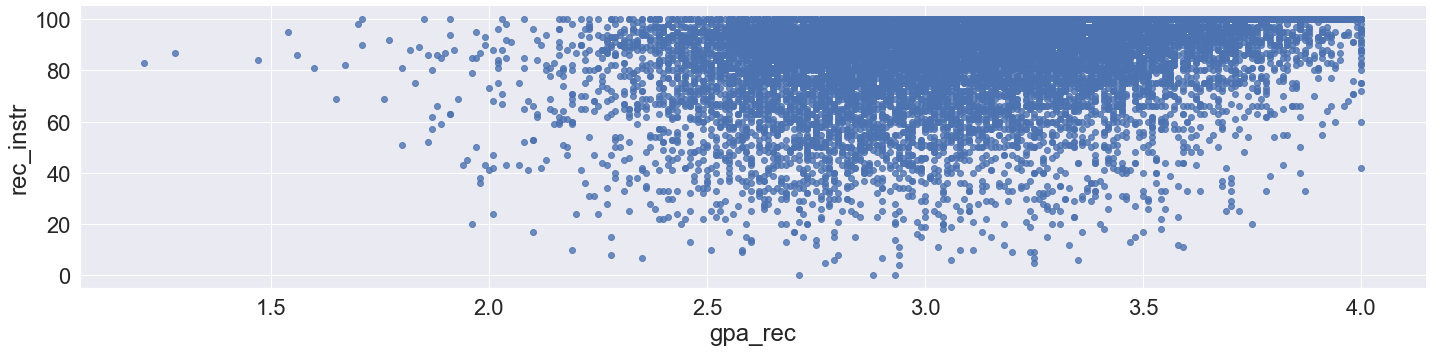

In [12]:
# Check the correlation between gpa_rec and rec_instr for STEM classes
sns.lmplot(x='gpa_rec', y='rec_instr', data=cape_stem, fit_reg=False, height = 5, aspect = 4);

In [13]:
# Construct and report a model that measures the relationship between gpa_rec & rec_instr
# for cape_stem
outcome1, predictor1 = patsy.dmatrices('rec_instr ~ gpa_rec', cape_stem)
model1 = sm.OLS(outcome1, predictor1)

results1 = model1.fit()

print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:              rec_instr   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     914.5
Date:                Tue, 23 Feb 2021   Prob (F-statistic):          8.11e-195
Time:                        21:39:28   Log-Likelihood:                -60614.
No. Observations:               14378   AIC:                         1.212e+05
Df Residuals:                   14376   BIC:                         1.212e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     51.2809      1.095     46.840      0.0

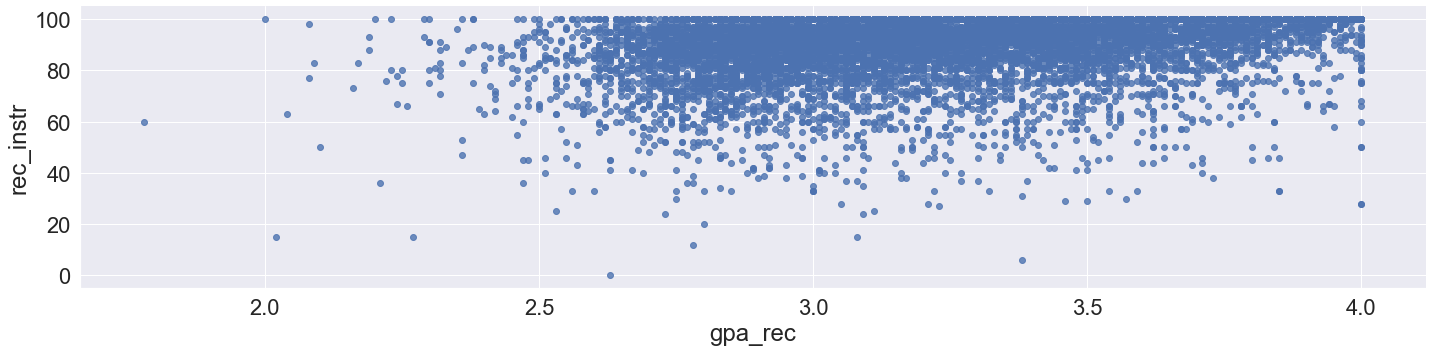

In [14]:
# Check the correlation between gpa_rec and rec_instr for social science classes
sns.lmplot(x='gpa_rec', y='rec_instr', data=cape_social_sci, fit_reg=False, height = 5, aspect = 4);

In [15]:
# Construct and report a model that measures the relationship between gpa_rec & rec_instr
# for cape_social_sci
outcome2, predictor2 = patsy.dmatrices('rec_instr ~ gpa_rec', cape_social_sci)
model2 = sm.OLS(outcome2, predictor2)

results2 = model2.fit()

print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:              rec_instr   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     736.8
Date:                Tue, 23 Feb 2021   Prob (F-statistic):          2.26e-156
Time:                        21:39:28   Log-Likelihood:                -37226.
No. Observations:                9582   AIC:                         7.446e+04
Df Residuals:                    9580   BIC:                         7.447e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.5526      1.087     54.799      0.0

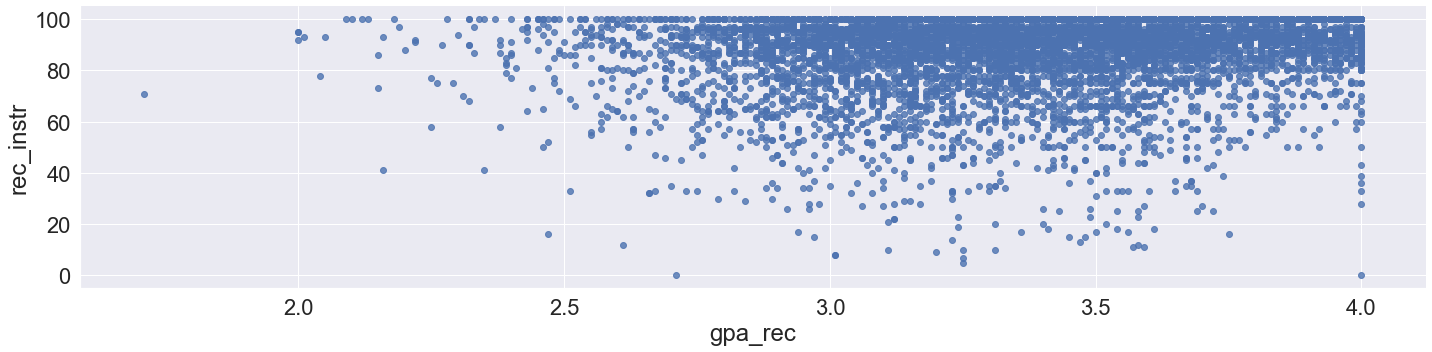

In [16]:
# Check the correlation between gpa_rec and rec_instr for humanities classes
sns.lmplot(x='gpa_rec', y='rec_instr', data=cape_hum, fit_reg = False, height = 5, aspect = 4);

In [17]:
# Construct and report a model that measures the relationship between gpa_rec & rec_instr
# for cape_hum
outcome3, predictor3 = patsy.dmatrices('rec_instr ~ gpa_rec', cape_hum)
model3 = sm.OLS(outcome3, predictor3)

results3 = model3.fit()

print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:              rec_instr   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     557.1
Date:                Tue, 23 Feb 2021   Prob (F-statistic):          1.46e-119
Time:                        21:39:29   Log-Likelihood:                -36335.
No. Observations:                8978   AIC:                         7.267e+04
Df Residuals:                    8976   BIC:                         7.269e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     57.3633      1.363     42.087      0.0